In [1]:
import math
from graphviz import Digraph

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), \
            "Only supporting integers or floats for now"
        
        out = Value(self.data**other, (self, ), _op=f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out =  Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# SOP
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [5]:
import torch

<h5> in comparison to pytorch

In [6]:
x1 = torch.Tensor([2.0]).double();      x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();      x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();      w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();      w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();    b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369


In [7]:
import random

In [8]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range((nout))]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def __repr__(self):
        return str(len(self.neurons))
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __repr__(self):
        res = ''
        for layer in self.layers:
           res += f"{layer}\n--------\n"
        return res
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [9]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [10]:
n.parameters()

[Value(data=-0.04381235955192042, grad=0.0),
 Value(data=-0.6753172329495223, grad=0.0),
 Value(data=0.09996082065690204, grad=0.0),
 Value(data=0.7194817041461767, grad=0.0),
 Value(data=-0.41510802991069085, grad=0.0),
 Value(data=0.8870395665781925, grad=0.0),
 Value(data=0.9081001516921909, grad=0.0),
 Value(data=0.1617859569333968, grad=0.0),
 Value(data=-0.7320157469106416, grad=0.0),
 Value(data=0.01765805331904491, grad=0.0),
 Value(data=-0.0913951189567157, grad=0.0),
 Value(data=-0.47076416616133754, grad=0.0),
 Value(data=0.4184021134889202, grad=0.0),
 Value(data=-0.3588585777465747, grad=0.0),
 Value(data=-0.7336100698486441, grad=0.0),
 Value(data=0.7491356660514668, grad=0.0),
 Value(data=-0.7641221985461424, grad=0.0),
 Value(data=-0.20924540753941234, grad=0.0),
 Value(data=-0.8122159219819165, grad=0.0),
 Value(data=0.731820668284823, grad=0.0),
 Value(data=0.7105030039191276, grad=0.0),
 Value(data=-0.9770486627629491, grad=0.0),
 Value(data=-0.2636730845257731, grad

<h5>simple dataset

In [11]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.6],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

Y = [1.0, -1.0, -1.0, 1.0]

In [29]:
for k in range(200):

    # forward pass
    ypred = [n(x) for x in X]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, Y))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update parameters

    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 0.0006208018314361593
1 0.0006206271348221608
2 0.0006204525340929939
3 0.0006202780291705711
4 0.0006201036199768595
5 0.00061992930643395
6 0.0006197550884639712
7 0.0006195809659891819
8 0.0006194069389319028
9 0.0006192330072145215
10 0.0006190591707595445
11 0.000618885429489531
12 0.0006187117833271444
13 0.0006185382321951181
14 0.0006183647760162785
15 0.0006181914147135262
16 0.0006180181482098588
17 0.0006178449764283399
18 0.0006176718992921115
19 0.0006174989167244311
20 0.0006173260286485988
21 0.0006171532349880299
22 0.0006169805356662011
23 0.0006168079306066751
24 0.0006166354197331054
25 0.0006164630029692202
26 0.0006162906802388243
27 0.0006161184514658152
28 0.0006159463165741642
29 0.0006157742754879343
30 0.0006156023281312553
31 0.000615430474428357
32 0.0006152587143035259
33 0.000615087047681148
34 0.0006149154744856903
35 0.0006147439946416844
36 0.0006145726080737668
37 0.0006144013147066339
38 0.0006142301144650697
39 0.0006140590072739457
40 0.0006138879

In [30]:
ypred = [n(x) for x in X]
ypred

[Value(data=0.9898805244963442, grad=0.0),
 Value(data=-0.9884783347538885, grad=0.0),
 Value(data=-0.9892957525911035, grad=0.0),
 Value(data=0.9845747041025468, grad=0.0)]

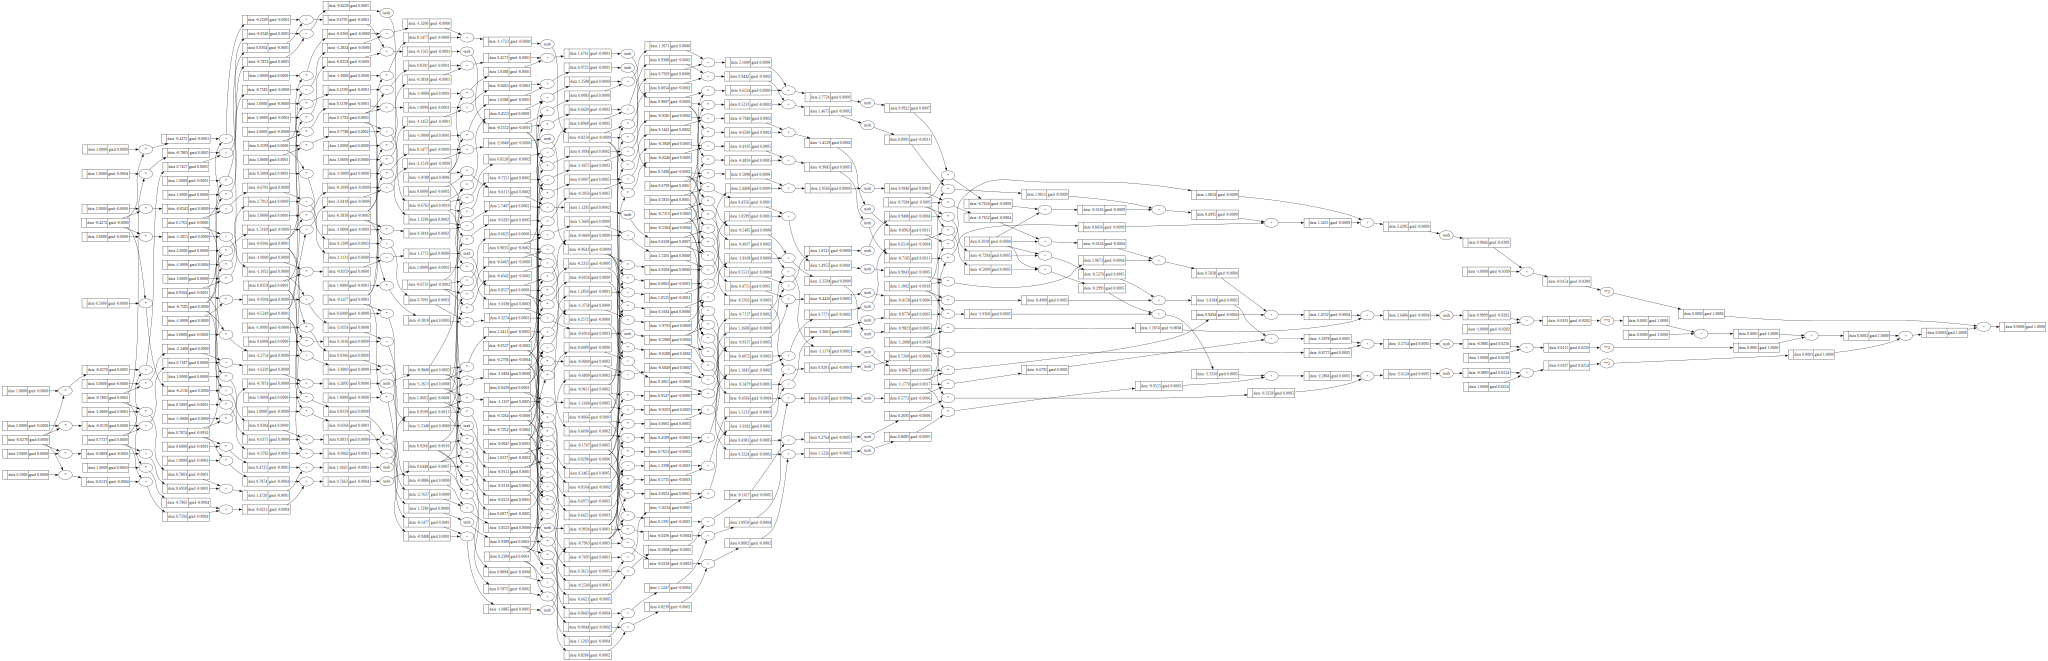

In [31]:
draw_dot(loss)